# Classification Experiments

In this notebook, I will collate the code from the pipeline notebook in a more efficient way, and then use it to try some different classification methods and features.

I'm taking a very naïve approach to trying different classifiers &mdash; I'm just going to use whatever the scikit-learn default is.

In [99]:
import collections
import itertools
import logging
import pprint
import sys
import warnings

import matplotlib.pyplot
import numpy
import scipy.linalg
import skimage.feature
import sklearn.cross_validation
import sklearn.decomposition
import sklearn.ensemble
import sklearn.linear_model
import sklearn.metrics
import sklearn.preprocessing
import sklearn.svm

sys.path.insert(1, '..')
import crowdastro.data
import crowdastro.rgz_analysis.consensus
import crowdastro.show

%matplotlib inline
warnings.simplefilter('ignore', UserWarning)  # astropy always raises warnings on Windows.

In [2]:
def make_annotation_signature(annotation):
    """Generates a unique signature from a single radio annotation."""
    if 'radio' not in annotation:
        # Metadata (ignore this).
        return None

    # Having no contours is a special case; () to avoid type errors (it's special but it's still valid!)
    if annotation['radio'] == 'No Contours':
        return ()

    # Round to fix floating point precision loss.
    # Sort to make sure this is deterministic.
    xmaxs = tuple(sorted([round(float(r['xmax']), 14) for r in annotation['radio'].values()]))
    ymaxs = tuple(sorted([round(float(r['ymax']), 14) for r in annotation['radio'].values()]))
    signature = (xmaxs, ymaxs)
    return signature

def make_classification_signature(classification):
    """Generates a unique signature from a complete radio classification."""
    classification_signature = []
    for annotation in classification['annotations']:
        annotation_signature = make_annotation_signature(annotation)
        if annotation_signature is not None:
            classification_signature.append(annotation_signature)

    classification_signature = tuple(sorted(classification_signature))
    return classification_signature

def plurality_classification_signature(subject):
    """Finds the most-chosen radio classification signature for a subject."""
    n_signatures = collections.Counter()
    
    for classification in crowdastro.data.db.radio_classifications.find({'subject_ids': subject['_id']}):
        classification_signature = make_classification_signature(classification)
        n_signatures[classification_signature] += 1

    return max(n_signatures, key=n_signatures.get)

def number_of_radio_sources(subject):
    """Finds the number of radio sources in a subject, according to volunteers."""
    return len(plurality_classification_signature(subject))

def filter_nice(subjects):
    """Yields nice subjects."""
    for subject in subjects:
        if number_of_radio_sources(subject) == 1:
            yield subject

def atlas_subjects():
    """Yields complete ATLAS subjects."""
    return crowdastro.data.db.radio_subjects.find({'metadata.survey': 'atlas', 'state': 'complete'})

def raw_training_data(subjects, radius=20):
    """Returns examples matrix X and targets matrix T.
    
    Each row of X is one example.
    Each row of T is one target.
    """
    xs = []
    ts = []
    
    subjects = list(subjects)  # In case this is a generator.
    
    for subject in subjects:
        # Find potential hosts.
        ir = crowdastro.data.get_ir(subject)
        blobs = skimage.feature.blob_log(ir/255, min_sigma=5, max_sigma=15, num_sigma=10, threshold=0.00002,
                                         overlap=0.75, log_scale=False)
        potential_hosts = numpy.fliplr(blobs[:, :2])
        
        # Find the label of each host.
        consensus = crowdastro.rgz_analysis.consensus.consensus(subject['zooniverse_id'])
        answers = list(consensus['answer'].values())
        
        classifications = numpy.zeros(potential_hosts.shape[0])
        
        if len(answers) != 1:
            # My plurality radio combination differs from Kyle Willett's - odd, but does happen.
            # Haven't solved this yet, so we'll take the noise hit for now and ignore the problem.
            logging.warning('Ignoring a subject due to unexpected number of answers ({}).'.format(len(answers)))
            continue

        if 'ir_peak' in answers[0]:
            true_host = numpy.array(answers[0]['ir_peak']) * 200 / 500  # Magic constant from web -> fits.
            true_host[1] = crowdastro.config.get('fits_image_height') - true_host[1]  # Clicks are flipped vertically.
            # Find the potential host closest to the true host. This is labelled 1; all else labelled 0.
            classifications[numpy.array([numpy.linalg.norm(diff) for diff in potential_hosts - true_host]).argmin()] = 1
        elif 'ir' in answers[0]:
            true_host = numpy.array(answers[0]['ir']) * 200 / 500
            true_host[1] = crowdastro.config.get('fits_image_height') - true_host[1]  # Clicks are flipped vertically.
            classifications[numpy.array([numpy.linalg.norm(diff) for diff in potential_hosts - true_host]).argmin()] = 1
        else:
            logging.warning('No click peaks found.')
        
        # Fetch the large image - that way, we don't need to impose artificial restrictions
        # on the edges of the image.
        radio = crowdastro.data.get_radio(subject, size='5x5')

        # Distance from edge of large image to edge of small image.
        border_radius = (crowdastro.config.get('fits_image_width') * 5 // 2 -
                         crowdastro.config.get('fits_image_width')) // 2

        # Get neighbourhoods around each host.
        for (host_x, host_y), label in zip(potential_hosts, classifications):
            host_x, host_y = int(host_x), int(host_y)
            neighbourhood = radio[border_radius + host_x - radius : border_radius + host_x + radius,
                                  border_radius + host_y - radius : border_radius + host_y + radius]
            xs.append(neighbourhood.flatten())
            ts.append(label)
    
    return numpy.array(xs), numpy.array(ts)

In [59]:
N = 100  # This uses about 2.2 GB of memory. I should try and compress on-the-fly when I have some features.
holdout = 100  # Skip + store the first holdout so we can test later on the full subjects.

subjects = filter_nice(atlas_subjects())
heldout = [s for _, s in zip(range(holdout), subjects)]
X, T = raw_training_data(itertools.islice(subjects, N), radius=20)

In [60]:
X_train, X_test, T_train, T_test = sklearn.cross_validation.train_test_split(X, T, test_size=0.2, random_state=0)

## Logistic regression
I've already done logistic regression in the pipeline notebook, but I would like to use it as a benchmark, so I reproduce it here. I also want to see the effect of preprocessing the data with sklearn (e.g. to scale it).

In [61]:
lr = sklearn.linear_model.LogisticRegression(class_weight='balanced')
lr.fit(X_train, T_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [62]:
# Raw confusion matrix.
pprint.pprint(sklearn.metrics.confusion_matrix(T_test, lr.predict(X_test)))

array([[757, 119],
       [  5,  11]])


In [77]:
# Perform the actual task, i.e., clicking the image in the right spot.

radius = 20

def predict(subject, lr, evaluate=False, preprocessor=None):
    # Get input data.
    xs = []
    ir = crowdastro.data.get_ir(subject)
    blobs = skimage.feature.blob_log(ir/255, min_sigma=5, max_sigma=15, num_sigma=10, threshold=0.00002,
                                     overlap=0.75, log_scale=False)
    potential_hosts = numpy.fliplr(blobs[:, :2])
    radio = crowdastro.data.get_radio(subject, size='5x5')
    border_radius = (crowdastro.config.get('fits_image_width') * 5 // 2 -
                     crowdastro.config.get('fits_image_width')) // 2
    for host_x, host_y in potential_hosts:
        host_x, host_y = int(host_x), int(host_y)
        neighbourhood = radio[border_radius + host_x - radius : border_radius + host_x + radius,
                              border_radius + host_y - radius : border_radius + host_y + radius]
        xs.append(neighbourhood.flatten())

    xs = numpy.array(xs)
    
    if preprocessor is None:
        ts = lr.predict_proba(xs)
    else:
        ts = lr.predict_proba(preprocessor.transform(xs))
    predicted_host = potential_hosts[ts[:, 1].argmax()]
    
    if not evaluate:
        return predicted_host

    # Get actual label for evaluation.
    consensus = crowdastro.rgz_analysis.consensus.consensus(subject['zooniverse_id'])
    answers = list(consensus['answer'].values())
    if len(answers) != 1:
        raise ValueError('Unexpected number of answers ({}).'.format(len(answers)))
    if 'ir_peak' in answers[0]:
        true_host = numpy.array(answers[0]['ir_peak']) * 200 / 500  # Magic constant from web -> fits.
        true_host[1] = crowdastro.config.get('fits_image_height') - true_host[1]  # Clicks are flipped vertically.
        # Find the potential host closest to the true host. This is labelled 1; all else labelled 0.
        closest = potential_hosts[numpy.array([numpy.linalg.norm(diff) for diff in potential_hosts - true_host]).argmin()]
    elif 'ir' in answers[0]:
        true_host = numpy.array(answers[0]['ir']) * 200 / 500
        true_host[1] = crowdastro.config.get('fits_image_height') - true_host[1]  # Clicks are flipped vertically.
        closest = potential_hosts[numpy.array([numpy.linalg.norm(diff) for diff in potential_hosts - true_host]).argmin()]
    else:
        closest = [-99, -99]
        logging.warning('No click peaks found.')
    return numpy.allclose(closest, predicted_host)

In [64]:
n_correct = 0
n_total = 0

for subject in heldout:
    try:
        c = predict(subject, lr, evaluate=True)
    except ValueError:
        continue
    
    n_correct += c
    n_total += 1
    
print('{:.02%}'.format(n_correct / n_total))

78.57%


### Scaling

In [66]:
scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
lr = sklearn.linear_model.LogisticRegression(class_weight='balanced')
lr.fit(scaler.transform(X_train), T_train)
pprint.pprint(sklearn.metrics.confusion_matrix(T_test, lr.predict(X_test)))

array([[600, 276],
       [  2,  14]])


In [78]:
n_correct = 0
n_total = 0

for subject in heldout:
    try:
        c = predict(subject, lr, evaluate=True, preprocessor=scaler)
    except ValueError:
        continue
    
    n_correct += c
    n_total += 1
    
print('{:.02%}'.format(n_correct / n_total))

73.47%


Interestingly, scaling seems to *reduce* performance. This may be due to the physical interpretation of each pixel (i.e., each pixel represents light).

## SVM

In [74]:
svc = sklearn.svm.SVC(class_weight='balanced', probability=True)
svc.fit(X_train, T_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [75]:
n_correct = 0
n_total = 0

for subject in heldout:
    try:
        c = predict(subject, svc, evaluate=True)
    except ValueError:
        continue
    
    n_correct += c
    n_total += 1
    
print('{:.02%}'.format(n_correct / n_total))

13.27%


This is considerably worse than logistic regression. It's possible that this is due to the low number of data points, but I can't increase that at the moment &mdash; I need to reconsider how I handle the data so I can avoid MemoryErrors first.

## Logistic regression with dimensionality reduction

In [81]:
svd = sklearn.decomposition.TruncatedSVD(n_components=200)
svd.fit(X_train)

lr = sklearn.linear_model.LogisticRegression(class_weight='balanced')
lr.fit(svd.transform(X_train), T_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [82]:
n_correct = 0
n_total = 0

for subject in heldout:
    try:
        c = predict(subject, lr, evaluate=True, preprocessor=svd)
    except ValueError:
        continue
    
    n_correct += c
    n_total += 1
    
print('{:.02%}'.format(n_correct / n_total))

75.51%


That's not too bad, and the data are many, many times smaller. We should look at the singular values matrix to see a good place to cut it off (I chose 200 really arbitrarily).

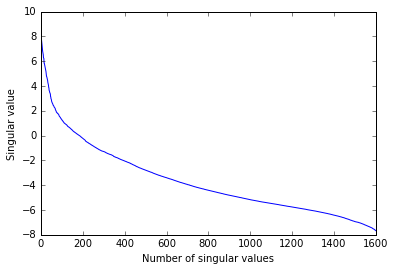

In [94]:
svd = scipy.linalg.svd(X_train)
U, S, V = svd
S.sort()
S = S[::-1]
matplotlib.pyplot.plot(numpy.log(S))
matplotlib.pyplot.xlabel('Number of singular values')
matplotlib.pyplot.ylabel('Singular value')
matplotlib.pyplot.show()

Interestingly, it looks like 200 might be a good choice after all. Now I can use this information to go back and preprocess all my data &mdash; it'll be 8 times smaller, so I can fit 8 times as many data points in. But first, I'll use it to preprocess data for the polynomial kernel &mdash; I couldn't do this earlier as I would get a MemoryError.

## Logistic regression with dimensionality reduction and polynomial kernel

In [96]:
svd = sklearn.decomposition.TruncatedSVD(n_components=200)
svd.fit(X_train)

poly = sklearn.preprocessing.PolynomialFeatures(2)
poly.fit(svd.transform(X_train))

lr = sklearn.linear_model.LogisticRegression(class_weight='balanced')
lr.fit(poly.transform(svd.transform(X_train)), T_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [98]:
n_correct = 0
n_total = 0

class PolySVD(object):
    def transform(self, xs):
        return poly.transform(svd.transform(xs))

for subject in heldout:
    try:
        c = predict(subject, lr, evaluate=True, preprocessor=PolySVD())
    except ValueError:
        continue
    
    n_correct += c
    n_total += 1
    
print('{:.02%}'.format(n_correct / n_total))

68.37%


This was pretty slow, and not better than linear.

## Random Forest

In [101]:
rfc = sklearn.ensemble.RandomForestClassifier()
rfc.fit(X_train, T_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [102]:
n_correct = 0
n_total = 0

for subject in heldout:
    try:
        c = predict(subject, rfc, evaluate=True)
    except ValueError:
        continue
    
    n_correct += c
    n_total += 1
    
print('{:.02%}'.format(n_correct / n_total))

52.04%


## SVM with dimensionality reduction

To put more data points into SVM, I'll need to do dimensionality reduction while processing the training data &mdash; I can only hold about 100 data points in memory otherwise.

In [112]:
def raw_training_data_svd(subjects, radius=20):
    """Returns examples matrix X and targets matrix T.
    
    Each row of X is one example.
    Each row of T is one target.
    """
    xs = []
    ts = []
    
    subjects = list(subjects)  # In case this is a generator.
    
    for subject in subjects:
        # Find potential hosts.
        ir = crowdastro.data.get_ir(subject)
        blobs = skimage.feature.blob_log(ir/255, min_sigma=5, max_sigma=15, num_sigma=10, threshold=0.00002,
                                         overlap=0.75, log_scale=False)
        potential_hosts = numpy.fliplr(blobs[:, :2])
        
        # Find the label of each host.
        consensus = crowdastro.rgz_analysis.consensus.consensus(subject['zooniverse_id'])
        answers = list(consensus['answer'].values())
        
        classifications = numpy.zeros(potential_hosts.shape[0])
        
        if len(answers) != 1:
            # My plurality radio combination differs from Kyle Willett's - odd, but does happen.
            # Haven't solved this yet, so we'll take the noise hit for now and ignore the problem.
            logging.warning('Ignoring a subject due to unexpected number of answers ({}).'.format(len(answers)))
            continue

        if 'ir_peak' in answers[0]:
            true_host = numpy.array(answers[0]['ir_peak']) * 200 / 500  # Magic constant from web -> fits.
            true_host[1] = crowdastro.config.get('fits_image_height') - true_host[1]  # Clicks are flipped vertically.
            # Find the potential host closest to the true host. This is labelled 1; all else labelled 0.
            classifications[numpy.array([numpy.linalg.norm(diff) for diff in potential_hosts - true_host]).argmin()] = 1
        elif 'ir' in answers[0]:
            true_host = numpy.array(answers[0]['ir']) * 200 / 500
            true_host[1] = crowdastro.config.get('fits_image_height') - true_host[1]  # Clicks are flipped vertically.
            classifications[numpy.array([numpy.linalg.norm(diff) for diff in potential_hosts - true_host]).argmin()] = 1
        else:
            logging.warning('No click peaks found.')
        
        # Fetch the large image - that way, we don't need to impose artificial restrictions
        # on the edges of the image.
        radio = crowdastro.data.get_radio(subject, size='5x5')

        # Distance from edge of large image to edge of small image.
        border_radius = (crowdastro.config.get('fits_image_width') * 5 // 2 -
                         crowdastro.config.get('fits_image_width')) // 2

        # Get neighbourhoods around each host.
        for (host_x, host_y), label in zip(potential_hosts, classifications):
            host_x, host_y = int(host_x), int(host_y)
            neighbourhood = radio[border_radius + host_x - radius : border_radius + host_x + radius,
                                  border_radius + host_y - radius : border_radius + host_y + radius]
            xs.append(svd.transform(numpy.array([neighbourhood.flatten()])))
            ts.append(label)
    
    return numpy.array(xs), numpy.array(ts)

In [121]:
N = 546 * 3 // 4
holdout = 546 // 4  # Skip + store the first holdout so we can test later on the full subjects.
subjects = filter_nice(atlas_subjects())
heldout = [s for _, s in zip(range(holdout), subjects)]
X, T = raw_training_data_svd(itertools.islice(subjects, N), radius=20)

In [122]:
X_train, X_test, T_train, T_test = sklearn.cross_validation.train_test_split(X, T, test_size=0.2, random_state=0)

In [126]:
X_train = X_train.reshape((-1, 200))
X_test = X_test.reshape((-1, 200))
T_train = T_train.reshape((-1, 1))
T_test = T_test.reshape((-1, 1))

In [127]:
svc = sklearn.svm.SVC(class_weight='balanced', probability=True)
svc.fit(X_train, T_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [133]:
n_correct = 0
n_total = 0

for subject in heldout:
    try:
        c = predict(subject, svc, evaluate=True, preprocessor=svd)
    except ValueError:
        continue
    
    n_correct += c
    n_total += 1
    
print('{:.02%}'.format(n_correct / n_total))

3.01%
